# Dual-module Bayesian Neural Network

TODO: intro



In [0]:
!pip install -q tf-nightly
!pip install -q tfp-nightly
!pip install -q catboost
!pip install -q --pre vaex

In [2]:
# Packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import vaex
from sklearn.dummy import DummyRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

# Settings
sns.set()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%config InlineBackend.figure_format = 'svg'
np.random.seed(111)
tf.set_random_seed(111)

Using TensorFlow backend.


## Data

TODO: explain, mention more eda in previous post

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# Columns to load
dtypes = {'fare_amount':      'float32',
          'pickup_datetime':  'str', 
          'pickup_longitude': 'float32',
          'pickup_latitude':  'float32',
          'dropoff_longitude':'float32',
          'dropoff_latitude': 'float32'}

# Load data
#train = pd.read_csv('train.csv', 
train = pd.read_csv('/content/gdrive/My Drive/DataScience/Data/train.zip', 
                    usecols=dtypes.keys(), 
                    dtype=dtypes,
                    nrows=100000)

# Convert pickup time column to datetime
train['pickup_datetime'] = train['pickup_datetime'].str.slice(0, 16)
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], 
                                          utc=True, 
                                          format='%Y-%m-%d %H:%M')

In [0]:
# Drop rows with empty values
train.dropna(inplace=True)

# Extract useful time information
train['min_of_day'] = (60*train['pickup_datetime'].dt.hour + 
                       train['pickup_datetime'].dt.minute).astype('int32')
train['day_of_week'] = train['pickup_datetime'].dt.dayofweek.astype('int32')
train['day_of_year'] = train['pickup_datetime'].dt.dayofyear.astype('int32')
train['year'] = train['pickup_datetime'].dt.year.astype('int32')

# Remove original datetime column
train.drop('pickup_datetime', axis=1, inplace=True)

# Ensure all columns are float32s
train = train.astype('float32')

# Function to remove rows outside range
def clip(df, a, b, col):
    for c in col:
        df = df[(df[c]>a) & (df[c]<b)]
    return df

# Remove outliers
train = clip(train, 1, 200, ['fare_amount'])
train = clip(train,  -75, -72.5,
             ['pickup_longitude', 'dropoff_longitude'])
train = clip(train, 40, 41.5,
             ['pickup_latitude', 'dropoff_latitude'])

# Make copy with untransformed data
train_orig = train.copy()

# Transform target column
train['fare_amount'] = np.log(np.log10(train['fare_amount']))

# Normalize data
train = (train - train.mean()) / train.std()

# Separate in- from dependent variables
x_taxi = train.drop('fare_amount', axis=1)
y_taxi = train['fare_amount']

## Baseline Models

In [0]:
# Make Mean Absolute Error scorer
mae_scorer = make_scorer(mean_absolute_error)

# Function to print cross-validated mean abs deviation
def cv_mae(regressor, x, y, cv=3, scorer=mae_scorer):
    scores = cross_val_score(regressor, 
                             x, y, cv=cv,
                             scoring=scorer)
    print('MAE:', scores.mean())

In [7]:
# MAE from predicting just the mean
cv_mae(DummyRegressor(), x_taxi, y_taxi)

MAE: 0.7929278612136841


In [8]:
# Distance between pickup and dropoff locations
dist = np.sqrt(
    np.power(x_taxi['pickup_longitude'] -
             x_taxi['dropoff_longitude'], 2) + 
    np.power(x_taxi['pickup_latitude'] - 
             x_taxi['dropoff_latitude'], 2))

# MAE from using just distance as predictor
cv_mae(IsotonicRegression(out_of_bounds='clip'), 
       dist, y_taxi)

MAE: 0.3673029410806102


## Vanilla Neural Network

TODO: talk about just prediction w/ nnet w/ MAE

In [9]:
# Run simple keras model to get MAE
model = Sequential([
    Dense(128, activation='relu', input_shape=(x_taxi.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation=None)
])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# Compile the model using MAE
model.compile('adam',
              loss='mean_absolute_error')

In [11]:
# Stop training when we start to overfit
callbacks = [EarlyStopping(restore_best_weights=True,
                           patience=2)]

# Fit the model
model.fit(x_taxi, y_taxi,
          batch_size=1000,  epochs=20,
          validation_split=0.5,
          callbacks=callbacks,  verbose=2)

Instructions for updating:
Use tf.cast instead.


Train on 48936 samples, validate on 48936 samples
Epoch 1/20
 - 1s - loss: 0.7744 - val_loss: 0.6853
Epoch 2/20
 - 1s - loss: 0.6836 - val_loss: 0.5897
Epoch 3/20
 - 1s - loss: 0.6104 - val_loss: 0.5050
Epoch 4/20
 - 0s - loss: 0.5602 - val_loss: 0.4603
Epoch 5/20
 - 1s - loss: 0.5148 - val_loss: 0.4195
Epoch 6/20
 - 1s - loss: 0.4712 - val_loss: 0.3827
Epoch 7/20
 - 1s - loss: 0.4423 - val_loss: 0.3638
Epoch 8/20
 - 1s - loss: 0.4239 - val_loss: 0.3574
Epoch 9/20
 - 1s - loss: 0.4141 - val_loss: 0.3562
Epoch 10/20
 - 1s - loss: 0.4100 - val_loss: 0.3549
Epoch 11/20
 - 1s - loss: 0.4056 - val_loss: 0.3484
Epoch 12/20
 - 0s - loss: 0.4008 - val_loss: 0.3472
Epoch 13/20
 - 1s - loss: 0.3964 - val_loss: 0.3449
Epoch 14/20
 - 1s - loss: 0.3948 - val_loss: 0.3402
Epoch 15/20
 - 1s - loss: 0.3925 - val_loss: 0.3419
Epoch 16/20
 - 0s - loss: 0.3892 - val_loss: 0.3349
Epoch 17/20
 - 1s - loss: 0.3887 - val_loss: 0.3379
Epoch 18/20
 - 1s - loss: 0.3873 - val_loss: 0.3313
Epoch 19/20
 - 0s - los

## Bayesian Neural network

TODO: fit the bayesian nnet w/ a single std dev param

In [0]:
# Settings
batch_size = 2000
max_steps = 1000
learning_rate = 0.001
Nmc = 100 #num samples to draw from posterior predictive

In [0]:
# DEBUGGER: reset the graph so you can re-run
tf.reset_default_graph() 

Split the data into a training set and a validation set

In [0]:
# Split data randomly into training + validation
tr_ind = np.random.choice([False, True],
                          size=x_taxi.shape[0])
x_train = x_taxi[tr_ind].values
y_train = y_taxi[tr_ind].values
x_val = x_taxi[~tr_ind].values
y_val = y_taxi[~tr_ind].values
N_train = x_train.shape[0]
N_val = x_val.shape[0]

Build an input data pipeline

In [0]:
def build_input_pipeline(x, y, x_val, y_val, batch_size, N_val):
  '''Build an Iterator switching between train and heldout data.
  Args:
    x: Numpy `array` of training features, indexed by the first dimension.
    y: Numpy `array` of training labels, with the same first dimension as `x`.
    x_val: Numpy `array` of validation features, indexed by the first dimension.
    y_val: Numpy `array` of validation labels, with the same first dimension as `x_val`.
    batch_size: Number of elements in each training batch.
    N_val: Number of examples in the validation dataset
  Returns:
    batch_features: `Tensor` feed  features, of shape
      `[batch_size] + x.shape[1:]`.
    batch_labels: `Tensor` feed of labels, of shape
      `[batch_size] + y.shape[1:]`.
  '''
  # Build an iterator over training batches.
  training_dataset = tf.data.Dataset.from_tensor_slices((x, y))
  training_batches = training_dataset.shuffle(
      50000, reshuffle_each_iteration=True).repeat().batch(batch_size)
  train_iterator = training_batches.make_one_shot_iterator()

  # Build a iterator over the validation set with batch_size=N_val,
  # i.e., return the entire heldout set as a constant.
  val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
  val_frozen = val_dataset.take(N_val).repeat().batch(N_val)
  val_iterator = val_frozen.make_one_shot_iterator()

  # Combine these into a feedable iterator that can switch between training
  # and validation inputs.
  handle = tf.placeholder(tf.string, shape=[])
  feedable_iterator = tf.data.Iterator.from_string_handle(
      handle, training_batches.output_types, training_batches.output_shapes)
  batch_features, batch_labels = feedable_iterator.get_next()

  return batch_features, batch_labels, handle, train_iterator, val_iterator

# Build input pipeline
x_vals, y_vals,  handle, training_iterator, validation_iterator = (
    build_input_pipeline(x_train, y_train, 
                         x_val, y_val, 
                         batch_size, N_val))

Function to make a variationally-inferred parameter....

In [0]:
def VariationalParameter(name, shape=[1], dtype=tf.float32):
  """Generates variational distribution(s)"""
  means = tf.get_variable(name+'_mean', 
                          dtype=dtype,
                          initializer=tf.ones([1]))
  stds = tf.get_variable(name+'_std', 
                         dtype=dtype,
                         initializer=-2.3*tf.ones([1]))
  return tfd.Normal(loc=means, 
                    scale=tf.math.exp(stds))

And a function to generate a densely-connected bayesian neural network with 1 continuous output.

In [0]:
# A dense network specified by a list of Nunits per layer
def DenseNetReg(units_per_layer, x_in):
  prior = tfp.layers.default_mean_field_normal_fn()
  layers = []
  for units in units_per_layer:
    layer = tfp.layers.DenseFlipout(
      units=units, 
      kernel_posterior_fn=prior,
      bias_posterior_fn=prior)
    x_in = layer(x_in)
    layers.append(layer)
  layer = tfp.layers.DenseFlipout( #final layer w/ no activation
      units=1, 
      activation=None,
      kernel_posterior_fn=prior,
      bias_posterior_fn=prior)
  layers.append(layer)
  return layers, layer(x_in)

And then we can build a model where the prediction is estimated by the bayesian neural network, and there is also an error term (which remains constant over the independent variable)

In [0]:
# A linear regression model: a Normal distribution
# parameterized by location from a dense multi-layer net,
# and std dev parameter
with tf.name_scope("bayesian_regression", values=[x_vals]):
  layers, predictions = DenseNetReg([128, 64], x_vals)
  constraint = tf.keras.constraints.NonNeg()
  noise_std = VariationalParameter('noise_std')
  pred_distribution = tfd.Normal(loc=predictions, 
                                 scale=tf.math.exp(noise_std.sample()))

To train the model , we'll use the evidence lower bound (ELBO) loss for variational inference, mean absolute error as a metric for evaluation, and the Adam optimizer.

In [0]:
# TODO: include the loss from the variational parameter's prior?

# Compute the -ELBO as the loss, averaged over the batch size
neg_log_likelihood = -tf.reduce_mean(pred_distribution.log_prob(y_vals))
kl_div = sum([sum(layer.losses) for layer in layers]) / N_train
elbo_loss = neg_log_likelihood + kl_div

# TODO: not sure whether to use predictions as predictions or the mean of the predictive distribution?
# does that include multiple draws from the flipout posterior?

# Mean absolute error metric for evaluation
mae, mae_update_op = tf.metrics.mean_absolute_error(
    #labels=y_vals, predictions=predictions)
    labels=y_vals, 
    predictions=tf.math.reduce_mean(pred_distribution.sample(100), 
                                    axis=0))

# Use ADAM optimizer w/ -ELBO loss
with tf.name_scope("train"):
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  train_op = optimizer.minimize(elbo_loss)

And now we can train the model while recording the weights over training.

In [116]:
%%time

# To store parameter values over training
noise_std_mean = noise_std.mean()
noise_std_std = noise_std.stddev()
noise_stds = np.zeros(max_steps)
noise_means = np.zeros(max_steps)
maes = np.zeros(max_steps)
losses = np.zeros(max_steps)

# Initialization op
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

# Run the training session
with tf.Session() as sess:
  sess.run(init_op)

  # Training loop
  train_handle = sess.run(training_iterator.string_handle())
  val_handle = sess.run(validation_iterator.string_handle())
  for iS in range(max_steps):
    [
        _,
        _,
        maes[iS],
        losses[iS],
        noise_means[iS],
        noise_stds[iS]
    ] = sess.run([
        train_op,
        mae_update_op,
        mae,
        elbo_loss,
        noise_std_mean,
        noise_std_std
    ], feed_dict={handle: train_handle})

  # Draw predictive distribution samples
  prediction_dists = sess.run((pred_distribution.sample(Nmc)), 
                              feed_dict={handle: val_handle})

CPU times: user 2min 8s, sys: 4.19 s, total: 2min 12s
Wall time: 1min 12s


TODO: look at stuff over the course of training

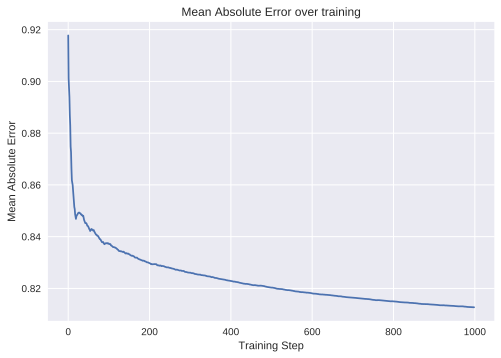

In [117]:
# Plot mean absoolute error over training
plt.figure()
plt.plot(maes[1:])
plt.xlabel('Training Step')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error over training')
plt.show()

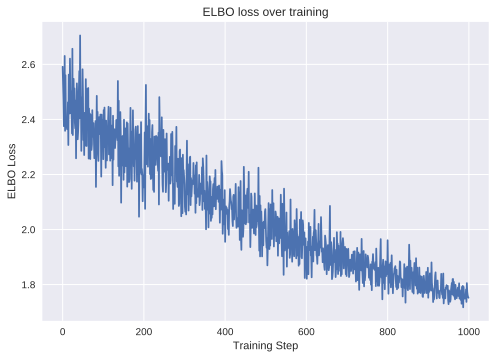

In [118]:
# Plot ELBO loss over training
plt.figure()
plt.plot(losses)
plt.xlabel('Training Step')
plt.ylabel('ELBO Loss')
plt.title('ELBO loss over training')
plt.show()

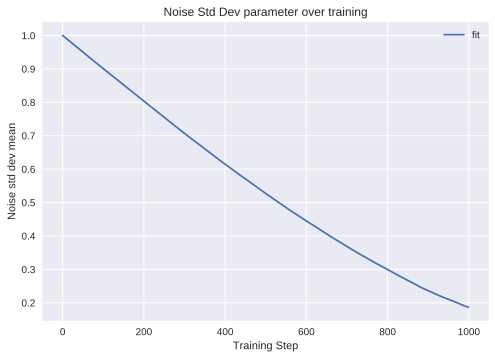

In [119]:
# Plot value of noise std dev over training
plt.figure()
plt.plot(noise_means, label='fit')
plt.xlabel('Training Step')
plt.ylabel('Noise std dev mean')
plt.title('Noise Std Dev parameter over training')
plt.legend()
plt.show()

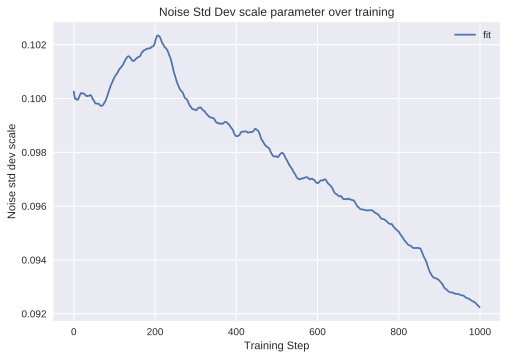

In [120]:
# Plot variance of noise std dev over training
plt.figure()
plt.plot(noise_stds, label='fit')
plt.xlabel('Training Step')
plt.ylabel('Noise std dev scale')
plt.title('Noise Std Dev scale parameter over training')
plt.legend()
plt.show()

TODO: look at predictive distributions

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

Text(0.5,0.98,'Predictive Distributions')

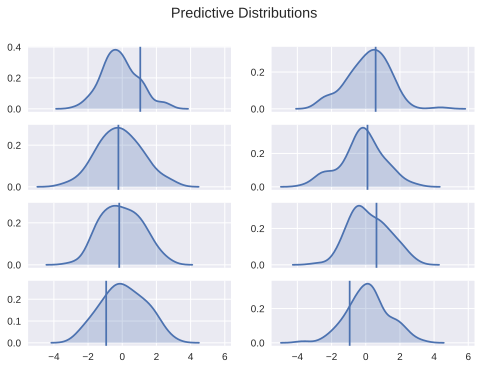

In [121]:
# Plot random datapoints and their prediction distributions
fig, axes = plt.subplots(4, 2, sharex='all')
for i in range(4):
  for j in range(2):
    ix = i*2+j
    sns.kdeplot(prediction_dists[:,ix,0], 
                shade=True, ax=axes[i][j])
    axes[i][j].axvline(x=y_val[ix])
plt.gcf().suptitle('Predictive Distributions')

TODO: compute the means of the predictive intervals and compute the MAE from that

In [0]:
TODO!!!!

TODO: compute the residual dist from the means

TODO: compute coverage of the 95% interval

In [79]:
def covered(dist, true, prc=95.0):
  q0 = (100-prc)/2.0 #lower percentile 
  q1 = 100-q0        #upper percentile
  within_conf_int = np.zeros(len(true))
  for i in range(len(true)):
    p0 = np.percentile(dist[:,i], q0)
    p1 = np.percentile(dist[:,i], q1)
    if p0<=true[i] and p1>true[i]:
      within_conf_int[i] = 1
  return within_conf_int

def coverage(dist, true, prc=95.0):
  return 100*np.mean(covered(dist, true, prc))

print('Coverage of 95%% predictive interval: %0.1f%%'
      % coverage(prediction_dists[:,:,0], y_val))

Coverage of 95% predictive interval: 96.9%


TODO: talk about how b/c we assumed a constant error term, the model doesn't handle the heterosskedastic nature of the data very well

TODO: look at coverage across time

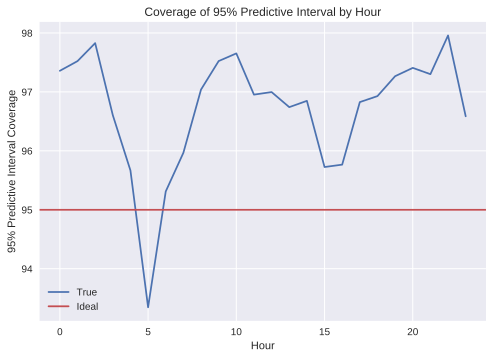

In [80]:
# Plot coverage as a fn of time of day
min_of_day = train_orig.loc[~tr_ind,'min_of_day'].values
covs = np.zeros(24)
for iT in range(0,24):
  ix = ((min_of_day>=(iT*60)) &
        (min_of_day<((iT+1)*60)))
  covs[iT] = coverage(prediction_dists[:,ix,0], y_val[ix])
plt.plot(covs, label='True')
plt.axhline(95.0, label='Ideal', color=colors[2])
plt.xlabel('Hour')
plt.ylabel('95% Predictive Interval Coverage')
plt.title('Coverage of 95% Predictive Interval by Hour')
plt.legend()
plt.show()

TODO: and we can also look at the coverage across pickup location

/usr/local/lib/python3.6/dist-packages/vaex/dataframe.py:1277: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(expression):
/usr/local/lib/python3.6/dist-packages/vaex/dataframe.py:1277: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(expression):


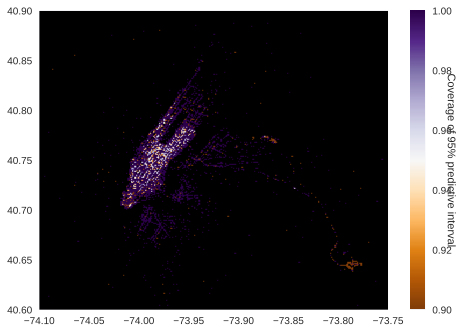

In [81]:
# Create vaex df with predictive intervals
cov_by_loc = pd.DataFrame()
cov_by_loc['x'] = train_orig.loc[~tr_ind,'pickup_longitude']
cov_by_loc['y'] = train_orig.loc[~tr_ind,'pickup_latitude']
cov_by_loc['covered'] = covered(prediction_dists[:,:,0], y_val)
vdf = vaex.from_pandas(cov_by_loc)

# Compute coverage of the predictive interval
lims = [[-74.1, -73.75],[40.6, 40.9]]
cov = vdf.mean(vdf.covered, limits=lims, shape=300,
               binby=[vdf.x,
                      vdf.y])

# Plot coverage of the predictive interval
cmap = matplotlib.cm.PuOr
cmap.set_bad('black', 1.)
plt.imshow(cov.T, origin='lower',
           vmin=0.9, vmax=1.0, cmap=cmap,
           extent=[lims[0][0], lims[0][1], 
                   lims[1][0], lims[1][1]])
ax = plt.gca()
ax.grid(False)
cbar = plt.colorbar()
cbar.set_label('Coverage of 95% predictive interval', 
               rotation=270)

TODO: not great! this is because our model assumes the error is constant across our independent variables.  To build a model which allows the error to vary across the predictors, we can build a model which predicts the uncertainty separately from the mean!

## Dual-Module Bayesian Neural Network

TODO: fit the bayesian nnet which separately estimates the unceratinty from the prediction

compare coverage of 95% interval and performance w/ heteroskedasticity to the first nnet

In [0]:
# DEBUGGER: reset the graph so you can re-run
tf.reset_default_graph() 

In [0]:
# Build fresh input pipeline
x_vals, y_vals,  handle, training_iterator, validation_iterator = (
    build_input_pipeline(x_train, y_train, 
                         x_val, y_val, 
                         batch_size, N_val))

In [0]:
# A linear regression model: a Normal distribution
# parameterized by location from a dense multi-layer net,
# and std dev from a separate dense multi-layer net
with tf.name_scope("dual_module_regression", values=[x_vals]):
  pred_layers, predictions = DenseNetReg([32, 16, 8], x_vals)  
  noise_layers, noise_std = DenseNetReg([32, 16, 8], x_vals)  
  pred_distribution = tfd.Normal(loc=predictions, 
                                 scale=tf.math.exp(noise_std))

In [0]:
# Compute the -ELBO as the loss, averaged over the batch size
neg_log_likelihood = -tf.reduce_mean(pred_distribution.log_prob(y_vals))
kl_div = (sum([sum(l.losses) for l in pred_layers]) +
          sum([sum(l.losses) for l in noise_layers])) / N_train
elbo_loss = neg_log_likelihood + kl_div

# Mean absolute error metric for evaluation
mae, mae_update_op = tf.metrics.mean_absolute_error(
    labels=y_vals, predictions=predictions)

# Use ADAM optimizer w/ -ELBO loss
with tf.name_scope("train"):
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  train_op = optimizer.minimize(elbo_loss)

In [86]:
%%time

# To store parameter values over training
maes = np.zeros(max_steps)
losses = np.zeros(max_steps)

# Initialization op
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

# Run the training session
with tf.Session() as sess:
  sess.run(init_op)

  # Training loop
  train_handle = sess.run(training_iterator.string_handle())
  val_handle = sess.run(validation_iterator.string_handle())
  for iS in range(max_steps):
    [
        _,
        _,
        maes[iS],
        losses[iS],
    ] = sess.run([
        train_op,
        mae_update_op,
        mae,
        elbo_loss,
    ], feed_dict={handle: train_handle})
  
  # Draw predictive distribution samples
  Nmc = 100
  prediction_dists_dual = sess.run((pred_distribution.sample(Nmc)), 
                                   feed_dict={handle: val_handle})

CPU times: user 2min 15s, sys: 3.1 s, total: 2min 18s
Wall time: 1min 15s


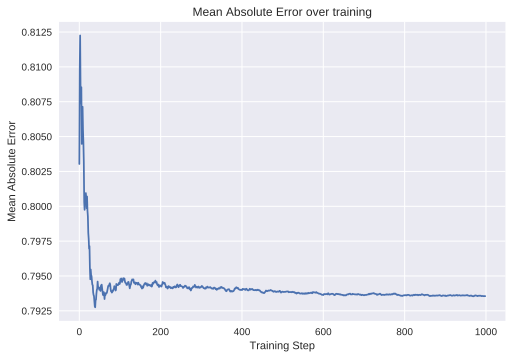

In [91]:
# Plot mean absoolute error over training
plt.figure()
plt.plot(maes[1:])
plt.xlabel('Training Step')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error over training')
plt.show()

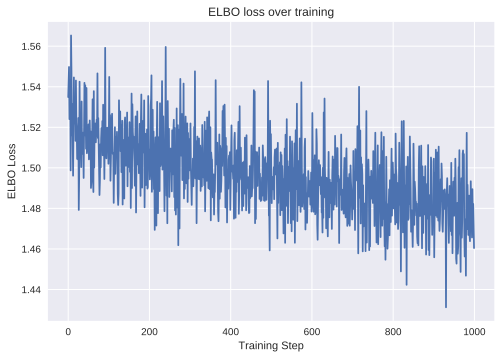

In [92]:
# Plot ELBO loss over training
plt.figure()
plt.plot(losses)
plt.xlabel('Training Step')
plt.ylabel('ELBO Loss')
plt.title('ELBO loss over training')
plt.show()

TODO: and we can look at some predictive distributions

TODO: compare to the predictive distributions of the model w/ constant error

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric

Text(0.5,0.98,'Predictive Distributions')

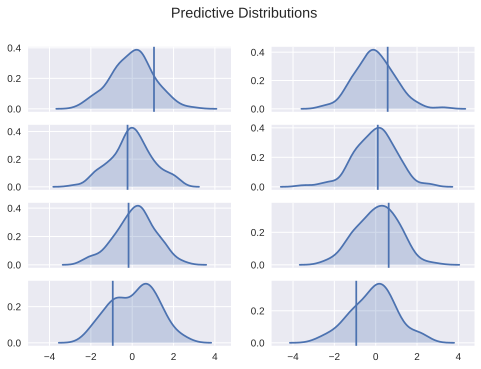

In [93]:
# Plot random datapoints and their prediction distributions
fig, axes = plt.subplots(4, 2, sharex='all')
for i in range(4):
  for j in range(2):
    ix = i*2+j
    sns.kdeplot(prediction_dists_dual[:,ix,0], 
                shade=True, ax=axes[i][j])
    axes[i][j].axvline(x=y_val[ix])
plt.gcf().suptitle('Predictive Distributions')

TODO: compute mean of predictive intervals and use that to compute MAE, and compare to that of the constant-error model

In [0]:
TODO!!!!

TODO: also compute residuals and compare the resid dist to that of the constant-error model

In [0]:
TODO!!!!

TODO: comparing the coverage of the 95% interval for the model w/ constant error vs the dual-module net

In [94]:
# Compare coverages between models
print('Coverage of 95%% interval for model w /constant error: %0.1f%%'
      % coverage(prediction_dists[:,:,0], y_val))
print('Coverage of 95%% interval for dual-module model: %0.1f%%'
      % coverage(prediction_dists_dual[:,:,0], y_val))

Coverage of 95% interval for model w /constant error: 96.9%
Coverage of 95% interval for dual-module model: 93.6%


TODO: and comparing the coverage between models as fn of time of day

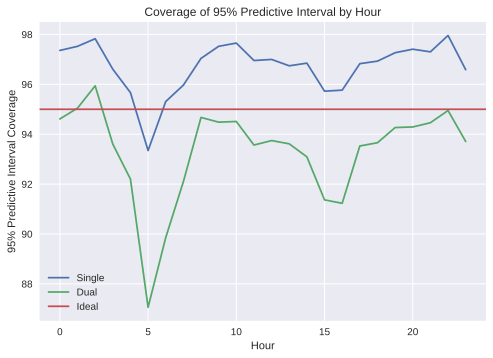

In [95]:
# Plot coverage as a fn of time of day
min_of_day = train_orig.loc[~tr_ind,'min_of_day'].values
covs_dual = np.zeros(24)
for iT in range(0,24):
  ix = ((min_of_day>=(iT*60)) &
        (min_of_day<((iT+1)*60)))
  covs_dual[iT] = coverage(prediction_dists_dual[:,ix,0], y_val[ix])
plt.plot(covs, label='Single')
plt.plot(covs_dual, label='Dual')
plt.axhline(95.0, label='Ideal', color=colors[2])
plt.xlabel('Hour')
plt.ylabel('95% Predictive Interval Coverage')
plt.title('Coverage of 95% Predictive Interval by Hour')
plt.legend()
plt.show()

TODO: and comparing coverage of interval across location

/usr/local/lib/python3.6/dist-packages/vaex/dataframe.py:1277: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(expression):
/usr/local/lib/python3.6/dist-packages/vaex/dataframe.py:1277: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(expression):
/usr/local/lib/python3.6/dist-packages/vaex/dataframe.py:1277: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(expression):
/usr/local/lib/python3.6/dist-packages/vaex/dataframe.py:1277: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(expression):


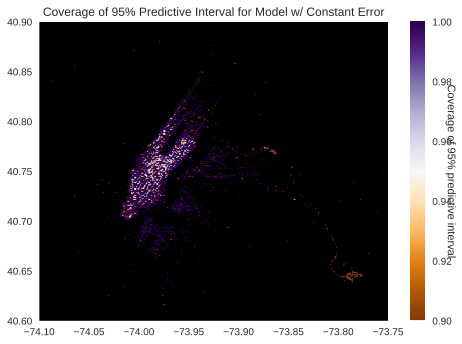

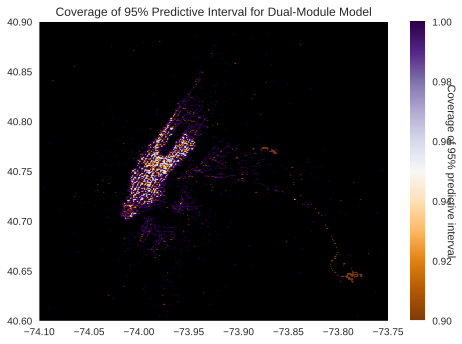

In [96]:
# Create vaex df with predictive intervals
cov_by_loc = pd.DataFrame()
cov_by_loc['x'] = train_orig.loc[~tr_ind,'pickup_longitude']
cov_by_loc['y'] = train_orig.loc[~tr_ind,'pickup_latitude']
cov_by_loc['covered'] = covered(prediction_dists[:,:,0], y_val)
cov_by_loc['cov_dual'] = covered(prediction_dists_dual[:,:,0], y_val)
vdf = vaex.from_pandas(cov_by_loc)

# Compute coverage of the predictive interval
lims = [[-74.1, -73.75],[40.6, 40.9]]
cov = vdf.mean(vdf.covered, limits=lims, shape=300,
               binby=[vdf.x, vdf.y])
cov_dual = vdf.mean(vdf.cov_dual, 
                    limits=lims, shape=300,
                    binby=[vdf.x, vdf.y])

# Plot coverage of the predictive interval
cmap = matplotlib.cm.PuOr
cmap.set_bad('black', 1.)
plt.imshow(cov.T, origin='lower',
           vmin=0.9, vmax=1.0, cmap=cmap,
           extent=[lims[0][0], lims[0][1], 
                   lims[1][0], lims[1][1]])
ax = plt.gca()
ax.grid(False)
cbar = plt.colorbar()
cbar.set_label('Coverage of 95% predictive interval', 
               rotation=270)
plt.title('Coverage of 95% Predictive Interval for Model w/ Constant Error')
plt.show()

# Plot coverage of the predictive interval
plt.imshow(cov_dual.T, origin='lower',
           vmin=0.9, vmax=1.0, cmap=cmap,
           extent=[lims[0][0], lims[0][1], 
                   lims[1][0], lims[1][1]])
ax = plt.gca()
ax.grid(False)
cbar = plt.colorbar()
cbar.set_label('Coverage of 95% predictive interval', 
               rotation=270)
plt.title('Coverage of 95% Predictive Interval for Dual-Module Model')
plt.show()

TODO: looks like the dual-module network handles heteroskedasticity better, but we can plot which is closer to 95% as a function of location

TODO: use a 2d colormap here? goes from red to blue depending on which model is better, but from bright to black depending on how many datapoints there are @ that pixel

Like here: https://github.com/JohannesBuchner/uncertaincolors

Could just do it manually (compute the color for each pixel, that is)

Maybe via a lambda func like this: https://stackoverflow.com/questions/41966600/matplotlib-colormap-with-two-parameter

And just use Blue (0,0,1) to red (1,0,0) for the colormap w/ brightness of the number of observations in that pixel (so multiply the color value by 0 if num obs=0 and by 1 if num obs = max num obs)

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


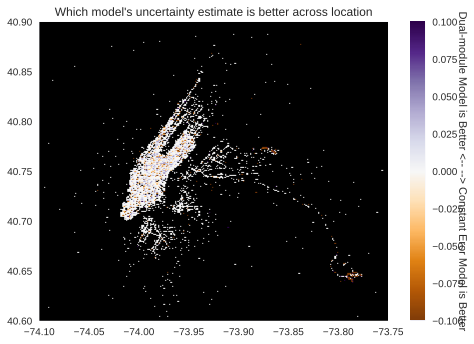

In [97]:
# Plot difference in deviation from 95% coverage
diff = np.abs(cov-0.95) - np.abs(cov_dual-0.95)
cmax = np.abs(diff).max()
plt.imshow(diff.T, 
           origin='lower', cmap=cmap,
           vmin=-cmax, vmax=cmax, 
           extent=[lims[0][0], lims[0][1], 
                   lims[1][0], lims[1][1]])
ax = plt.gca()
ax.grid(False)
cbar = plt.colorbar()
cbar.set_label('Dual-module Model is Better <-- --> Constant Eror Model is Better', 
               rotation=270)
plt.title('Which model\'s uncertainty estimate is better across location')
plt.show()

TODO: and zooming in on Jersey city and Hoboken, we can see that the dual module net is far better at predicting the uncertainty there than the constant-error net

/usr/local/lib/python3.6/dist-packages/vaex/dataframe.py:1277: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(expression):
/usr/local/lib/python3.6/dist-packages/vaex/dataframe.py:1277: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(expression):
/usr/local/lib/python3.6/dist-packages/vaex/dataframe.py:1277: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(expression):
/usr/local/lib/python3.6/dist-packages/vaex/dataframe.py:1277: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(expression):
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


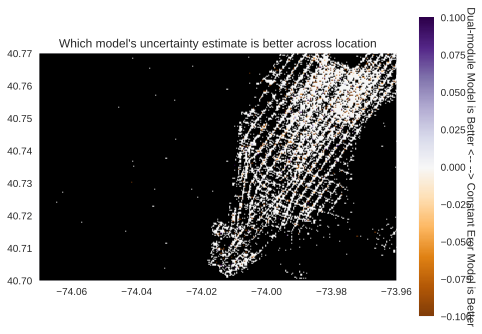

In [98]:
# Compute coverage of the predictive interval
lims = [[-74.07, -73.96],[40.70, 40.77]]
cov = vdf.mean(vdf.covered, limits=lims, shape=300,
               binby=[vdf.x, vdf.y])
cov_dual = vdf.mean(vdf.cov_dual, 
                    limits=lims, shape=300,
                    binby=[vdf.x, vdf.y])

# TODO: plot of abs(cov_dual-0.95)-abs(cov-0.95)
# Plot difference in deviation from 95% coverage
diff = np.abs(cov-0.95) - np.abs(cov_dual-0.95)
cmax = np.abs(diff).max()
plt.imshow(diff.T, 
           origin='lower', cmap=cmap,
           vmin=-cmax, vmax=cmax, 
           extent=[lims[0][0], lims[0][1], 
                   lims[1][0], lims[1][1]])
ax = plt.gca()
ax.grid(False)
cbar = plt.colorbar()
cbar.set_label('Dual-module Model is Better <-- --> Constant Eror Model is Better', 
               rotation=270)
plt.title('Which model\'s uncertainty estimate is better across location')
plt.show()

TODO: talk about how the dual-module net handles heteroskedasticity much better!